In [3]:
from netCDF4 import Dataset
import osgeo.osr as osr
from osgeo import gdal
import numpy as np
from os import path, listdir
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
def AAIGrid_to_geotiff(filein, EPSG_code):
    """ 
    Lecture d'un raster au format ESRI Ascii Grid et conversion en geotiff    
    filein : chemin complet du fichier geotiff 
    EPSG_code : code de géoréférencement (EX : 2154 (Lambert 93), 4326 (WGS84), 
    """
    fileout = path.splitext(filein)
    fileout = fileout[0] + '.tif'
    drv = gdal.GetDriverByName('GTiff')
    ds_in = gdal.Open(filein)
    ds_out = drv.CreateCopy(fileout, ds_in)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(EPSG_code)
    ds_out.SetProjection(srs.ExportToWkt())
    ds_in = None
    ds_out = None

In [5]:
import sys
sys.path.append(r"C:\Program Files\GDAL")
import gdal_merge as gdalmerge

def merge_rasters(pathin):
    """
    Merge tous les geotiffs contenus dans un répertoire en un seul.
    Utilise le script gdal_merge.py dans le répertoire d'installation de GDAL.
    """    
    args = ['', '-o', path.join(pathin, 'merged.tif')]
    numfile = 0
    for f in listdir(pathin):       
        if path.isfile(path.join(pathin, f)) and path.splitext(f)[-1] == '.tif':
            numfile += 1
            # récupe de la valeur de nodata
            if numfile == 1:           
                _, metadata = raster_to_array(path.join(pathin,f))
                nodata_args = ['-init', "{}".format(metadata['noDataValue']),
                               '-n', "{}".format(metadata['noDataValue']),
                               '-a_nodata', "{}".format(metadata['noDataValue'])]
                for a in nodata_args:
                    args.append(a) 
            
            args.append(path.join(pathin,f))
    # exécution de GDAL_merge        
    gdalmerge.main(args)

In [6]:
def reproject_raster(raster_in, EPSG_code):    
    """
    Reprojection du raster vers EPSG_code.
    raster_in : chemin complet du raster en entrée
    EPSG_code : code EPSG (par ex : 32663 pour WGS 84 / World Equidistant Cylindrical)
    """
    basefilename, _ = path.splitext(raster_in)
    output_raster = basefilename + '_EPSG{}'.format(EPSG_code) + '.tif'  
    gdal.Warp(output_raster, raster_in, dstSRS='EPSG:{}'.format(EPSG_code))
    return output_raster

In [7]:
def raster_to_array(geotif_file):
    """ 
    Lecture d'un geotiff et conversion en tableau numpy.
    Fonctionne pour des rasters a plusieurs bandes (RVB par ex)
    geotif_file : chemin complet du fichier geotiff 
    """
    
    metadata = {}
    dataset = gdal.Open(geotif_file)
    if dataset == None:
        print("raster_to_array : problème d'ouverture de fichier")
    
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    xMin = mapinfo[0]
    xMax = mapinfo[0] + dataset.RasterXSize * mapinfo[1]
    yMin = mapinfo[3] + dataset.RasterYSize * mapinfo[5]
    yMax = mapinfo[3]

    metadata['extent'] = (xMin,xMax,yMin,yMax)

    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(
        0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()

    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix

    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()

        array = dataset.GetRasterBand(1).ReadAsArray( 
            0, 0, metadata['array_cols'], metadata['array_rows']).astype(np.float)
        #array[np.where(array==metadata['noDataValue'])]=np.nan
        array = array / metadata['scaleFactor']

    elif metadata['bands'] > 1:    
        for i in range(1, dataset.RasterCount+1):
            band = dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
            #band[np.where(band==metadata['noDataValue'])]=np.nan
            band = band/metadata['scaleFactor']
            array[...,i-1] = band
    
    print("Lecture terminée :\n\t{}\n".format(geotif_file))
    return array, metadata

In [8]:
def array_to_raster(array, metadata, dst_filename):
                    #,  x_min, x_pixel_size, y_max, y_pixel_size, wkt_projection):
    """
    Ecriture d'un geotiff à partir d'un tableau numpy.    
    :array : tableau numpy
    :metadata : dictionnaire contenant les propriétés du tableau (cf. raster_to_array)
    :dst_filename : chemin complet du fichier de sortie 
    """ 
    [y_pixels, x_pixels] = array.shape    

    driver = gdal.GetDriverByName('GTiff')

    dataset = driver.Create(
        dst_filename,
        x_pixels,
        y_pixels,
        1,
        gdal.GDT_Float32, )

    dataset.SetGeoTransform([
        metadata['extent'][0],    # 0
        metadata['pixelWidth'],  # 1
        0,                      # 2
        metadata['extent'][3],    # 3
        0,                      # 4
        -metadata['pixelHeight']])  

    dataset.SetProjection(metadata['projection'])
    dataset.GetRasterBand(1).WriteArray(np.flipud(array))
    dataset.GetRasterBand(1).SetNoDataValue(metadata['noDataValue'])
    dataset.FlushCache()  # Write to disk.
    dataset = None

In [20]:
def array_to_dtm(array, metadata, file_name_out):
    """ 
    Export d'un tableau numpy contenant des flottants en DTM Globe/Caraibes
    array : tableau numpy
    metadata : dictionnaire contenant les propriétés du tableau (cf. raster_to_array)
    file_name_out : nom complet du fichier de sortie
    """
    
    # creation du géoréférencement à partir des méta données
    array_cs = osr.SpatialReference(metadata['projection'])    
    f = 1/array_cs.GetInvFlattening() # applatissement inverse
    E2 = 2*f - f**2
    
    # mise à l'échelle nous-même de la variable DEPTH
    array[array == metadata['noDataValue']] = np.NaN    
    ScaleFactor, Offset, Minimum_value, Maximum_value, MissingValue = computeScaledVar(array)    
    print('\nScaleFactor : ',ScaleFactor,
          '\nOffset : ',Offset,
          '\nMinimum_value :', Minimum_value,
          '\nMaximum_value :', Maximum_value,
          '\nMissingValue :', MissingValue)        
    array =(array - Offset)/ScaleFactor
    array[np.isnan(array)] = MissingValue
    
    # affichage du tableau transmis pour écriture
    plt.imshow(array, interpolation='none', cmap=cm.jet, extent=metadata['extent'])
    plt.colorbar()
    plt.show()
        
    # calcul de la position des pixels
    COLUMNS = np.linspace(metadata['extent'][0], metadata['extent'][1], metadata['array_cols'], endpoint=True)
    LINES   = np.linspace(metadata['extent'][2], metadata['extent'][3], metadata['array_rows'], endpoint=True)        
    
    # creation de la déprojection
    wgs84_cs = array_cs.CloneGeogCS()        
    arrayCs_To_WGS84 = osr.CoordinateTransformation(array_cs, wgs84_cs)
    
    # calculs des coordonnées géographiques des coins
    BL_coordinates = arrayCs_To_WGS84.TransformPoint(metadata['extent'][0], metadata['extent'][2])
    BR_coordinates = arrayCs_To_WGS84.TransformPoint(metadata['extent'][1], metadata['extent'][2])
    TR_coordinates = arrayCs_To_WGS84.TransformPoint(metadata['extent'][1], metadata['extent'][3])    
    TL_coordinates = arrayCs_To_WGS84.TransformPoint(metadata['extent'][0], metadata['extent'][3])
    
    # ouverture du fichier
    dtm_file = Dataset(file_name_out, 'w', format='NETCDF3_CLASSIC') 
    
    # Global Attributes 
    dtm_file.CIB_BLOCKS_FOR_UNLIMITED = 1
    dtm_file.mbVersion = 200
    dtm_file.mbName = file_name_out
    dtm_file.mbClasse = ""
    dtm_file.mbLevel = 0
    dtm_file.mbNbrHistoryRec = 1
    dtm_file.mbTimeReference = "Julian date for 1970/01/01 = 2 440 588"
    dtm_file.mbStartDate = 0
    dtm_file.mbStartTime = 0
    dtm_file.mbEndDate = 0
    dtm_file.mbEndTime = 0    
    dtm_file.mbNorthLatitude = max([TR_coordinates[1], TL_coordinates[1]])
    dtm_file.mbSouthLatitude = min([BR_coordinates[1], BL_coordinates[1]])
    dtm_file.mbEastLongitude = max([TR_coordinates[0], BR_coordinates[0]])
    dtm_file.mbWestLongitude = min([BL_coordinates[0], TL_coordinates[0]])
    dtm_file.mbMeridian180 = "" 
    dtm_file.mbGeoDictionnary = "" 
    dtm_file.mbGeoRepresentation = ""
    dtm_file.mbGeodesicSystem = ""  
    dtm_file.mbEllipsoidName = "WGS-84"
    dtm_file.mbEllipsoidA = array_cs.GetSemiMajor() 
    dtm_file.mbEllipsoidInvF = array_cs.GetInvFlattening()
    dtm_file.mbEllipsoidE2 = E2
    dtm_file.mbProjType = 1
    dtm_file.mbProjParameterValue = "" #"[-3.  0. 30.  0.  0.]"
    dtm_file.mbProjParameterCode = "" #"MB_M0,MB_HEMI,MB_FUSEAU,MB_X0,MB_Y0"
    dtm_file.mbProj4String = array_cs.ExportToProj4()
    dtm_file.Conventions = "CF-1.4"
    dtm_file.Type = "DTM"
    dtm_file.Format = "STR"
    dtm_file.Mosaic_type = "GEO"
    dtm_file.Sounder_type = 69
    dtm_file.Number_lines = metadata['array_rows']
    dtm_file.Number_columns = metadata['array_cols']
    dtm_file.Element_x_size = metadata['pixelWidth']
    dtm_file.Element_y_size = abs(metadata['pixelHeight'])
    dtm_file.Orientation = 0.0
    dtm_file.Latitude_BL  = BL_coordinates[1]  
    dtm_file.Longitude_BL = BL_coordinates[0] 
    dtm_file.Latitude_TL  = TL_coordinates[1] 
    dtm_file.Longitude_TL = TL_coordinates[0] 
    dtm_file.Latitude_TR  = TR_coordinates[1] 
    dtm_file.Longitude_TR = TR_coordinates[0] 
    dtm_file.Latitude_BR  = BR_coordinates[1] 
    dtm_file.Longitude_BR = BR_coordinates[0] 
    dtm_file.Xmin_metric = metadata['extent'][0] 
    dtm_file.Xmax_metric = metadata['extent'][1]
    dtm_file.Ymin_metric = metadata['extent'][2]
    dtm_file.Ymax_metric = metadata['extent'][3]
    dtm_file.Number_layers = 1
    
    # creation des dimensions 
    dim = {'CIB_BLOCK_DIM':1024,
            'mbHistoryRecNbr' : 20,
            'mbNameLength' : 20,
            'mbCommentLength' : 256,
            'mbLabelLength' : 40,
            'LAYERS_HEADERS' : 20,
            'LINES': metadata['array_rows'],
            'COLUMNS': metadata['array_cols']
          }
    
    for dim_name, dim_value in dim.items():
        dtm_file.createDimension(dim_name, dim_value)        
    
    # creation des variables
    grid_mapping_name = array_cs.GetAttrValue('PROJECTION')
    if grid_mapping_name is None :
        grid_mapping_name = 'latitude_longitude'
            
    
    var = {grid_mapping_name : {'dtype': 'S1'},
           'mbHistDate' : {'dtype': np.int32 ,'dimensions':('mbHistoryRecNbr',)},
           'mbHistTime' : {'dtype': np.int32 ,'dimensions':('mbHistoryRecNbr',)},
           'mbHistCode' : {'dtype': 'S1' ,'dimensions':('mbHistoryRecNbr',)}, 
           'mbHistAutor' : {'dtype': 'S1' ,'dimensions':('mbHistoryRecNbr', 'mbNameLength')}, 
           'mbHistModule' : {'dtype': 'S1' ,'dimensions':('mbHistoryRecNbr', 'mbNameLength')},
           'mbHistComment' : {'dtype': 'S1' ,'dimensions':('mbHistoryRecNbr', 'mbCommentLength')}, 
           'Layer_name' : {'dtype': 'S1' ,'dimensions':('LAYERS_HEADERS', 'mbNameLength')},
           'COLUMNS' : {'dtype': np.float64 ,'dimensions':('COLUMNS',)}, 
           'LINES' : {'dtype': np.float64 ,'dimensions':('LINES',)}, 
           'DEPTH' : {'dtype': np.int16 ,'dimensions': ('LINES', 'COLUMNS')}             
          }
            
    for var_name, var_value in var.items():
        print("creating variable : {}...".format(var_name))
        if 'dimensions' in var_value:
            dtm_var = dtm_file.createVariable(var_name, var_value['dtype'], var_value['dimensions']) 
        else:
            dtm_var = dtm_file.createVariable(var_name, var_value['dtype'])                 
        
        # Variable Attributes communs
        dtm_var.long_name = var_name
        dtm_var.units = "meter"
        print("writting variable : {}...".format(var_name))
        
        # écriture des variables
        if var_name == 'COLUMNS':
            # Variable Attributes           
            dtm_var.standard_name = "projection_x_coordinate"
            # Variable data
            dtm_var[:] = COLUMNS  
            
        elif var_name == 'LINES':
            # Variable Attributes            
            dtm_var.standard_name = "projection_y_coordinate"
            # Variable data
            dtm_var[:] = LINES 
            
        elif var_name == 'DEPTH':            
            # Variable Attributes             
            dtm_var.layer_type = "DTM"
            dtm_var.element_type = chr(3)           
            dtm_var.add_offset = Offset
            dtm_var.scale_factor = ScaleFactor
            dtm_var.valid_minimum = Minimum_value
            dtm_var.valid_maximum = Maximum_value
            dtm_var.first_line = 1
            dtm_var.last_line = metadata['array_rows']
            dtm_var.first_column = 1
            dtm_var.last_column = metadata['array_cols']
            dtm_var.ext_missing_value = 9.969209968386869E36
            dtm_var.layer_min_value = Minimum_value #np.nanmin(array) 
            dtm_var.layer_max_value = Maximum_value #np.nanmax(array)
            dtm_var.data_type = "NONE"
            dtm_var.processing_method = ""
            dtm_var.element_length = chr(3)
            dtm_var.missing_value = MissingValue            
            dtm_var.esri_pe_string = metadata['projection']    
            dtm_var.grid_mapping = grid_mapping_name            
            # Variable data
            dtm_var.set_auto_scale(False)
            
            dtm_var[:] = np.flipud(array)
            
        elif var_name == grid_mapping_name:
            dtm_var.grid_mapping_name = grid_mapping_name
            dtm_var.scale_factor_at_central_meridian = array_cs.GetProjParm('scale_factor')
            dtm_var.longitude_of_central_meridian = array_cs.GetProjParm('central_meridian')
            dtm_var.latitude_of_projection_origin = array_cs.GetProjParm('latitude_of_origin')
            dtm_var.false_easting = array_cs.GetProjParm('false_easting')
            dtm_var.false_northing = array_cs.GetProjParm('false_northing')
            dtm_var.inverse_flattening = array_cs.GetInvFlattening() #298.257223563
            dtm_var.semi_major_axis = array_cs.GetSemiMajor() #6378137.0
            dtm_var.longitude_of_prime_meridian = 0.0
            dtm_var.long_name = "CRS definition"
            dtm_var.spatial_ref = array_cs.ExportToWkt() #'PROJCS["UTM Zone 30, Northern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["Meter",1]]'
            dtm_var.prime_meridian_name = 'Greenwich'
            dtm_var.horizontal_datum_name = array_cs.GetAttrValue('DATUM') #'WGS_1984'
            dtm_var.crs_wkt = array_cs.ExportToWkt() #'PROJCS["UTM Zone 30, Northern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["Meter",1]]
            dtm_var.reference_ellipsoid_name = array_cs.GetAttrValue('SPHEROID') #'WGS 84'
            dtm_var.geographic_crs_name = array_cs.GetAttrValue('geogcs')
            if grid_mapping_name is not 'latitude_longitude':
                dtm_var.projected_crs_name = array_cs.GetAttrValue('projcs') #'UTM Zone 30, Northern Hemisphere'
            
        
    # écriture du fichier
    dtm_file.close() 
    print("DTM export successfull :\n\t{}\n".format(file_name_out))
    
def computeScaledVar(Data):
    """Mise à l'échelle de la variable pour écriture dans un 'NC_SHORT' (16 bits)"""
    valueRange = 2**15-2
    MissingValue  = []
    Offset        = np.nanmin(Data)
    ScaleFactor   = (np.nanmax(Data) - np.nanmin(Data)) / valueRange
    Minimum_value = (np.nanmin(Data) - Offset ) / ScaleFactor
    Maximum_value = (np.nanmax(Data) - Offset ) / ScaleFactor
    MissingValue  = np.float64(np.iinfo(np.int16).max)
        
    return ScaleFactor, Offset, Minimum_value, Maximum_value, MissingValue

In [10]:
def raster_to_dtm(raster_file):
    """ 
    Conversion d'un geotiff en DTM    
    raster_file : nom complet du geotiff en entrée
    """
    array, metadata = raster_to_array(raster_file)
    # suppression des zones non couvertes par Litto3D
    #array[array == 0] = np.NaN 
    #array[array == metadata['noDataValue']] = np.NaN 
    basefilename, _ = path.splitext(raster_file)
    file_name_out = basefilename + '.dtm'
    array_to_dtm(array, metadata, file_name_out)

In [ ]:
######################
# Test des fonctions
######################

In [12]:
# Transcodage des .asc vers geotiff
pathin = r"C:\TEMP\Armen-CapSizun-Litto3DBrut\1-Chaussee-Sein"
for f in listdir(pathin):       
    if path.isfile(path.join(pathin, f)) and path.splitext(f)[-1] == '.asc':
        print("exporting {} to geotiff".format(f) )
        AAIGrid_to_geotiff(path.join(pathin, f), 2154) #2154 = ESPG code pour Lambert 93

exporting LITTO3D_FRA_0119_6797_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0119_6798_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0119_6799_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0119_6800_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0119_6801_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0119_6802_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0119_6803_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0119_6804_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0120_6796_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0120_6797_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0120_6798_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0120_6799_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0120_6800_MNT_20141222_LAMB93_

exporting LITTO3D_FRA_0131_6800_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0131_6801_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0131_6802_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0131_6803_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0131_6804_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0132_6796_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0132_6797_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0132_6798_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0132_6799_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0132_6800_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0132_6801_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0132_6802_MNT_20141222_LAMB93_RGF93_IGN69.asc to geotiff
exporting LITTO3D_FRA_0132_6803_MNT_20141222_LAMB93_

In [30]:
# Merge des geotiff en un seul
merge_rasters(pathin)

Lecture terminée :
	C:\TEMP\Armen-CapSizun-Litto3DBrut\cap_merged_EPSG32663.tif



In [31]:
# Reprojection de lambert93 vers Cylindrique équidistant
geotif_file = path.join(pathin, 'merged.tif')
reproject_raster(geotif_file, 32663)

'C:\\TEMP\\Armen-CapSizun-Litto3DBrut\\merged_EPSG32663.tif'

Lecture terminée :
	C:\TEMP\Armen-CapSizun-Litto3DBrut\chausse_merged_EPSG32663.tif


ScaleFactor :  0.0022910944178363003 
Offset :  -40.2599983215332 
Minimum_value : 0.0 
Maximum_value : 32766.0 
MissingValue : 32767.0


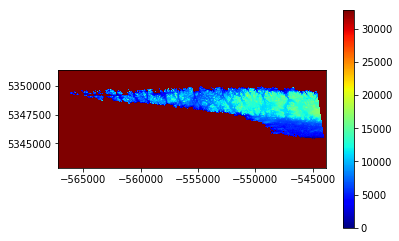

creating variable : Equirectangular...
writting variable : Equirectangular...
creating variable : mbHistDate...
writting variable : mbHistDate...
creating variable : mbHistTime...
writting variable : mbHistTime...
creating variable : mbHistCode...
writting variable : mbHistCode...
creating variable : mbHistAutor...
writting variable : mbHistAutor...
creating variable : mbHistModule...
writting variable : mbHistModule...
creating variable : mbHistComment...
writting variable : mbHistComment...
creating variable : Layer_name...
writting variable : Layer_name...
creating variable : COLUMNS...
writting variable : COLUMNS...
creating variable : LINES...
writting variable : LINES...
creating variable : DEPTH...
writting variable : DEPTH...
DTM export successfull :
	C:\TEMP\Armen-CapSizun-Litto3DBrut\chausse_merged_EPSG32663.dtm



In [23]:
# Export en DTM netCDF
geotif_file = r'C:\TEMP\Armen-CapSizun-Litto3DBrut\chausse_merged_EPSG32663.tif'
raster_to_dtm(geotif_file)